<a href="https://colab.research.google.com/github/TyagiAka/252506_DBDA/blob/main/AI_Based_Disaster_Detection_and_Rescue_Support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Implement an AI-Based Disaster Detection and Rescue Support system using the C2A dataset. The system detect multiple natural disasters (floods, earthquakes, tsunamis, fires) and the number of people stuck, and based on this information, provide support team recommendations to enhance disaster response efficiency and support affected communities. The system quickly identifies disaster events and suggests appropriate emergency resources like rescue teams, medical aid, shelters, food, and evacuation plans. The goal is to enhance disaster response efficiency, reduce harm, and support affected communities in recovery through timely, tailored resource recommendations." The dataset is located at "/content/drive/MyDrive/C2A.zip".

## Setup environment and mount drive

### Subtask:
Install necessary libraries and mount Google Drive to access the dataset.


In [41]:
!pip install ultralytics
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and extract dataset

### Subtask:
Load the zipped C2A dataset from Google Drive and extract its contents to a local directory.


In [42]:
import zipfile
import os

# Define the corrected path to the zipped dataset in Google Drive
zip_path = '/content/drive/MyDrive/archive (2).zip'

# Define the path to the local directory where the dataset will be extracted
extract_path = '/content/c2a_dataset'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Use the zipfile module to open and extract the contents of the zipped dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: /content/c2a_dataset


## Data preparation and preprocessing for human detection

### Subtask:
Define the classes for object detection (initially 'human'), organize the extracted image and annotation files, convert annotations to the YOLO format, split the dataset into training and validation sets, and prepare data loaders for the YOLO model.


In [43]:
# List the contents of the extracted dataset directory
!ls /content/c2a_dataset/C2A_Dataset/new_dataset3/

# List the contents of the train and val directories to see the image and label files
!ls /content/c2a_dataset/C2A_Dataset/new_dataset3/train/
!ls /content/c2a_dataset/C2A_Dataset/new_dataset3/val/

'All labels with Pose information'   data.yaml	 test   train   val
collapsed_building  flood   labels	  traffic_incident
fire		    images  labels.cache  train_annotations.json
collapsed_building  flood   labels	  traffic_incident
fire		    images  labels.cache  val_annotations.json


Parse the COCO format JSON annotation files, convert the annotations to YOLO format, and save the YOLO annotations to corresponding text files in the appropriate train and validation directories. This addresses steps 2, 3, and 4 of the subtask.



In [44]:
import json
import os

def coco_to_yolo(coco_bbox, image_width, image_height):
    """Converts COCO bounding box [x_min, y_min, width, height] to YOLO format [x_center, y_center, width, height]."""
    x_min, y_min, width, height = coco_bbox
    x_center = (x_min + width / 2) / image_width
    y_center = (y_min + height / 2) / image_height
    w_norm = width / image_width
    h_norm = height / image_height
    return [x_center, y_center, w_norm, h_norm]

def convert_annotations(json_path, image_dir, output_label_dir):
    """Converts COCO annotations in a JSON file to YOLO format .txt files."""
    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    # Create output directory if it doesn't exist
    os.makedirs(output_label_dir, exist_ok=True)

    # Create a dictionary to map image_id to image information (including width and height)
    image_info = {img['id']: (img['width'], img['height'], img['file_name']) for img in coco_data['images']}

    # Create a dictionary to store annotations per image
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)

    # Process annotations for each image
    for image_id, annotations in annotations_by_image.items():
        img_width, img_height, file_name = image_info[image_id]
        # YOLO label file name should match the image file name (but with .txt extension)
        label_file_name = os.path.splitext(file_name)[0] + '.txt'
        label_file_path = os.path.join(output_label_dir, label_file_name)

        with open(label_file_path, 'w') as f:
            for ann in annotations:
                # Assuming 'human' is category_id 0 as observed in the sample annotation
                category_id = ann['category_id'] # This should be 0 for 'human'
                yolo_bbox = coco_to_yolo(ann['bbox'], img_width, img_height)
                # Write the YOLO format: class_index center_x center_y width height
                f.write(f"{category_id} {yolo_bbox[0]:.6f} {yolo_bbox[1]:.6f} {yolo_bbox[2]:.6f} {yolo_bbox[3]:.6f}\n")

    print(f"Converted annotations from {json_path} to YOLO format in {output_label_dir}")

# Define paths
base_dataset_path = '/content/c2a_dataset/C2A_Dataset/new_dataset3'
train_json_path = os.path.join(base_dataset_path, 'train', 'train_annotations.json')
val_json_path = os.path.join(base_dataset_path, 'val', 'val_annotations.json')

train_image_dir = os.path.join(base_dataset_path, 'train', 'images')
val_image_dir = os.path.join(base_dataset_path, 'val', 'images')

train_label_dir = os.path.join(base_dataset_path, 'train', 'labels')
val_label_dir = os.path.join(base_dataset_path, 'val', 'labels')

# Convert train and validation annotations
convert_annotations(train_json_path, train_image_dir, train_label_dir)
convert_annotations(val_json_path, val_image_dir, val_label_dir)

# Verify a few created label files
print("\nVerifying generated label files:")
!ls {train_label_dir} | head -n 5
!ls {val_label_dir} | head -n 5

Converted annotations from /content/c2a_dataset/C2A_Dataset/new_dataset3/train/train_annotations.json to YOLO format in /content/c2a_dataset/C2A_Dataset/new_dataset3/train/labels
Converted annotations from /content/c2a_dataset/C2A_Dataset/new_dataset3/val/val_annotations.json to YOLO format in /content/c2a_dataset/C2A_Dataset/new_dataset3/val/labels

Verifying generated label files:
collapsed_building_image0001_0.txt
collapsed_building_image0001_1.txt
collapsed_building_image0001_2.txt
collapsed_building_image0001_4.txt
collapsed_building_image0002_0.txt
collapsed_building_image0003_1.txt
collapsed_building_image0005_0.txt
collapsed_building_image0006_0.txt
collapsed_building_image0006_2.txt
collapsed_building_image0006_3.txt


Create the `data.yaml` configuration file required by YOLO, specifying the paths to the training and validation image and label directories, the number of classes, and the class names.



In [45]:
import yaml

# Define the content of the data.yaml file
data_yaml_content = {
    'train': os.path.join(base_dataset_path, 'train', 'images'), # Path to training images
    'val': os.path.join(base_dataset_path, 'val', 'images'),     # Path to validation images
    'nc': 1,                                                     # Number of classes
    'names': ['human']                                           # Class names
}

# Define the path where the data.yaml file will be saved
data_yaml_path = os.path.join(base_dataset_path, 'data.yaml')

# Write the content to the data.yaml file
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_yaml_content, f, default_flow_style=None)

print(f"Created data.yaml file at: {data_yaml_path}")

# Display the content of the created data.yaml file
with open(data_yaml_path, 'r') as f:
    print("\nContent of data.yaml:")
    print(f.read())

Created data.yaml file at: /content/c2a_dataset/C2A_Dataset/new_dataset3/data.yaml

Content of data.yaml:
names: [human]
nc: 1
train: /content/c2a_dataset/C2A_Dataset/new_dataset3/train/images
val: /content/c2a_dataset/C2A_Dataset/new_dataset3/val/images



## Model building and Training: human detection

### Subtask:
 Add YOLO model architecture (e.g., YOLOv8) and initialize the YOLO model, potentially using pre-trained weights.


In [46]:
from ultralytics import YOLO

# Choose a YOLOv8 model architecture (e.g., 'yolov8n.pt' for nano model with pre-trained weights)
model_architecture = 'yolov8n.pt'

# Instantiate the YOLO model
model = YOLO(model_architecture)

# Print the model to inspect its layers
#print(model)
results = model.train(data=data_yaml_path, epochs=2, batch=32)

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/c2a_dataset/C2A_Dataset/new_dataset3/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train17, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

train: Scanning /content/c2a_dataset/C2A_Dataset/new_dataset3/train/labels.cache... 6129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6129/6129 [00:00<?, ?it/s]

train: /content/c2a_dataset/C2A_Dataset/new_dataset3/train/images/flood_image0407_3.png: 1 duplicate labels removed


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1691.1±567.3 MB/s, size: 321.9 KB)


val: Scanning /content/c2a_dataset/C2A_Dataset/new_dataset3/val/labels.cache... 2043 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2043/2043 [00:00<?, ?it/s]

Plotting labels to runs/detect/train17/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train17
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.677      1.478      1.073        649        640: 100%|██████████| 192/192 [30:14<00:00,  9.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [05:54<00:00, 11.08s/it]


                   all       2043      72123      0.727      0.551      0.594      0.315

1 epochs completed in 0.603 hours.
Optimizer stripped from runs/detect/train17/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train17/weights/best.pt, 6.2MB

Validating runs/detect/train17/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [04:19<00:00,  8.10s/it]


                   all       2043      72123      0.726      0.551      0.593      0.315
Speed: 2.3ms preprocess, 87.0ms inference, 0.0ms loss, 19.2ms postprocess per image
Results saved to runs/detect/train17


#Model Evaluation : Human detection

In [65]:
print("Evaluating Human Detection Model...")

yolo_results = model.val(data=data_yaml_path) # Reverted to using data_yaml_path

    # Print YOLO evaluation metrics
print("\n Human Detection Model Evaluation Complete!")
print(" YOLO Evaluation Metrics:")
print(f"  mAP@0.5: {yolo_results.results_dict.get('metrics/mAP50(B)', 'N/A'):.4f}")
print(f"  mAP@0.5:0.95: {yolo_results.results_dict.get('metrics/mAP50-95(B)', 'N/A'):.4f}")
print(f"  Precision: {yolo_results.results_dict.get('metrics/Precision(B)', 'N/A'):.4f}")
print(f"  Recall: {yolo_results.results_dict.get('metrics/Recall(B)', 'N/A'):.4f}")

Evaluating Human Detection Model...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)


FileNotFoundError: [34m[1mval: [0mError loading data from /content/c2a_dataset/C2A_Dataset/new_dataset3/val/images
See https://docs.ultralytics.com/datasets for dataset formatting guidance.

## Data preparation and preprocessing for disaster type classification

### Subtask:
Infer disaster types from image filenames or directory structure, define the classes for image classification based on inferred types, organize images into class-specific subfolders for training and validation, and prepare data loaders for the image classification model, including necessary preprocessing steps like resizing and normalization.


In [47]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define base paths
base_dataset_path = '/content/c2a_dataset/C2A_Dataset/new_dataset3'
train_base_path = os.path.join(base_dataset_path, 'train')
val_base_path = os.path.join(base_dataset_path, 'val')

# Define disaster types (still based on the expected filenames)
disaster_types = ['collapsed_building', 'flood', 'fire', 'traffic_incident']
print(f"Using disaster types for classification: {disaster_types}")

# Re-create directories to ensure a clean state before moving
for dtype in disaster_types:
    train_dir = os.path.join(train_base_path, dtype)
    val_dir = os.path.join(val_base_path, dtype)
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)
    os.makedirs(train_dir)
    os.makedirs(val_dir)
    print(f"Cleaned and re-created directories for {dtype} in train and val.")


# Function to move images based on filename string matching
def organize_images_by_filename_match(src_image_dir, dest_base_dir, disaster_types_list):
    moved_count = 0
    for filename in os.listdir(src_image_dir):
        src_path = os.path.join(src_image_dir, filename)
        if os.path.isfile(src_path):
            moved = False
            for dtype in disaster_types_list:
                if dtype in filename: # Check if the disaster type string is in the filename
                    dest_dir = os.path.join(dest_base_dir, dtype)
                    dest_path = os.path.join(dest_dir, filename)
                    try:
                        shutil.move(src_path, dest_path)
                        moved_count += 1
                        # print(f"Moved {filename} to {dest_dir}")
                        moved = True
                        break
                    except Exception as e:
                        print(f"Error moving {filename} to {dest_dir}: {e}")
                        moved = True # Treat as moved to avoid "not moved" warning if error occurs after finding type
                        break # Stop searching for type if a match is found

            if not moved:
                print(f"Warning: Could not determine disaster type from filename: {filename}. Leaving in original location.")
    print(f"Successfully moved {moved_count} images from {src_image_dir}")


train_image_dir_original = os.path.join(train_base_path, 'images')
val_image_dir_original = os.path.join(val_base_path, 'images')

print("\nOrganizing training images based on filename...")
organize_images_by_filename_match(train_image_dir_original, train_base_path, disaster_types)

print("\nOrganizing validation images based on filename...")
organize_images_by_filename_match(val_image_dir_original, val_base_path, disaster_types)


# 4. Verify the organization by listing contents
print("\nVerifying organization after filename-based move:")
for dtype in disaster_types:
    print(f"\nContents of train/{dtype} (first 5):")
    !ls {os.path.join(train_base_path, dtype)} | head -n 5
    print(f"Contents of val/{dtype} (first 5):")
    !ls {os.path.join(val_base_path, dtype)} | head -n 5


print(f"\nContents of original train/images (first 5):")
!ls {train_image_dir_original} | head -n 5
print(f"Contents of original val/images (first 5):")
!ls {val_image_dir_original} | head -n 5


# Prepare data loaders for image classification
image_size = (224, 224) # Define image_size here
batch_size = 32 # Define batch_size here
img_height, img_width = image_size # Use the previously defined image size (224, 224)
batch_size_val = batch_size # Use the previously defined batch size (32)

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Add other augmentation parameters if needed, e.g., rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

# Only normalization for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_base_path, # Point to the base train directory containing class subfolders
    target_size=(img_height, img_width),
    batch_size=batch_size_val,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    classes=disaster_types # Explicitly set classes to ensure order and mapping
)

val_generator = val_datagen.flow_from_directory(
    val_base_path, # Point to the base val directory containing class subfolders
    target_size=(img_height, img_width),
    batch_size=batch_size_val,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    classes=disaster_types # Explicitly set classes to ensure order and mapping
)

print("\nTraining and validation data generators created.")
print(f"Training classes: {train_generator.class_indices}")
print(f"Validation classes: {val_generator.class_indices}")

Using disaster types for classification: ['collapsed_building', 'flood', 'fire', 'traffic_incident']
Cleaned and re-created directories for collapsed_building in train and val.
Cleaned and re-created directories for flood in train and val.
Cleaned and re-created directories for fire in train and val.
Cleaned and re-created directories for traffic_incident in train and val.

Organizing training images based on filename...
Successfully moved 6129 images from /content/c2a_dataset/C2A_Dataset/new_dataset3/train/images

Organizing validation images based on filename...
Successfully moved 2043 images from /content/c2a_dataset/C2A_Dataset/new_dataset3/val/images

Verifying organization after filename-based move:

Contents of train/collapsed_building (first 5):
collapsed_building_image0001_0.png
collapsed_building_image0001_1.png
collapsed_building_image0001_2.png
collapsed_building_image0001_4.png
collapsed_building_image0002_0.png
Contents of val/collapsed_building (first 5):
collapsed_build

## Model building and Training: disaster type classification

### Subtask:
Choose a suitable image classification model architecture (e.g., a pre-trained model like ResNet or EfficientNet for transfer learning), load the pre-trained weights, and modify the final layers for the specific number of disaster classes.


In [48]:

# Create the model before compiling and training
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2


# Define the base pre-trained model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new Keras Functional API model on top of the frozen base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a final dense layer with num_classes units and softmax activation
num_classes = len(disaster_types)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model_classification = Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model_classification.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Train the model
# Use default epochs if not defined
try:
    num_epochs = 5
except NameError:
    num_epochs = 5 # Default epochs

history = model_classification.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator
)

print("\nImage classification model training complete.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 1310s 7s/step - accuracy: 0.7571 - loss: 0.6207 - val_accuracy: 0.9476 - val_loss: 0.1526
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 1292s 7s/step - accuracy: 0.9657 - loss: 0.1294 - val_accuracy: 0.9682 - val_loss: 0.1107
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 1287s 7s/step - accuracy: 0.9762 - loss: 0.0861 - val_accuracy: 0.9775 - val_loss: 0.0788
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 1285s 7s/step - accuracy: 0.9860 - loss: 0.0596 - val_accuracy: 0.9814 - val_loss: 0.0656
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 1288s 7s/step - accuracy: 0.9919 - loss: 0.0445 - val_accuracy: 0.9853 - val_loss: 0.0562

Image classification model training complete.


## Model Evaluation:disaster type classification



In [54]:
loss, accuracy = model_classification.evaluate(val_generator)

# Print classification evaluation metrics
print("\n Disaster Type Classification Model Evaluation Complete!")
print(" Classification Evaluation Metrics:")
print(f"  Validation Loss: {loss:.4f}")
print(f"  Validation Accuracy: {accuracy:.4f}")



64/64 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.9884 - loss: 0.0498

 Disaster Type Classification Model Evaluation Complete!
 Classification Evaluation Metrics:
  Validation Loss: 0.0562
  Validation Accuracy: 0.9853


## Model Integration and Resource Recommendation Logic

### Subtask:
Integrate the two trained models (human detection and disaster type classification). Develop logic to analyze an image using both models and recommend appropriate emergency resources based on the detected human count and the classified disaster type.

**Reasoning**:
Define a function or class that takes an image path, runs the human detection model to get bounding boxes and counts, runs the image classification model to determine the disaster type, and then uses these results to apply a resource recommendation strategy.

In [56]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input # Assuming ResNet was used for classification

RESCUE_RESOURCES = {
    'collapsed_building': {
        'no_humans': ['Search and rescue dogs', 'Structural assessment team', 'Heavy equipment'],
        'low_density': ['Ground rescue teams (small)', 'Medical aid (basic)', 'Search and rescue dogs'],
        'medium_density': ['Ground rescue teams (multiple)', 'Medical aid (advanced)', 'Temporary shelter assessment'],
        'high_density': ['Multiple rescue teams (heavy urban search and rescue)', 'Medical triage setup', 'Temporary shelters', 'Food and water supplies']
    },
    'flood': {
        'no_humans': ['Flood damage assessment', 'Infrastructure check'],
        'low_density': ['Water rescue team (small boat)', 'Medical aid (basic)', 'Evacuation route assessment'],
        'medium_density': ['Water rescue teams (multiple boats)', 'Medical aid (advanced)', 'Evacuation support', 'Temporary shelters'],
        'high_density': ['Multiple water rescue teams (boats/helicopters)', 'Medical triage setup', 'Temporary shelters', 'Food and water supplies', 'Evacuation plans']
    },
    'fire': {
        'no_humans': ['Fire damage assessment', 'Safety perimeter setup'],
        'low_density': ['Firefighting units (local)', 'Medical aid (basic)'],
        'medium_density': ['Firefighting units (multiple)', 'Medical aid (advanced)', 'Evacuation route assessment'],
        'high_density': ['Multiple firefighting units (regional support)', 'Medical triage setup', 'Temporary shelters', 'Evacuation plans']
    },
    'traffic_incident': {
        'no_humans': ['Traffic management', 'Scene cleanup'],
        'low_density': ['Police/Emergency medical (basic)', 'Tow trucks'],
        'medium_density': ['Multiple police/emergency medical', 'Traffic management', 'Accident investigation'],
        'high_density': ['Major incident response team', 'Medical triage setup', 'Heavy recovery equipment']
    },
     'other': { # Default for uncategorized or unknown disaster types
        'no_humans': ['General assessment team'],
        'low_density': ['Basic rescue team', 'Medical aid (basic)'],
        'medium_density': ['Multiple rescue teams', 'Medical aid (advanced)'],
        'high_density': ['Major rescue operations', 'Medical triage setup']
    }
}

class IntegratedDisasterSystem:
    def __init__(self, yolo_model, classification_model, classification_class_names):
        self.yolo_model = yolo_model
        self.classification_model = classification_model
        self.classification_class_names = classification_class_names
        print("Integrated Disaster System Initialized")

    def classify_disaster_type(self, image_path):
        """Classify the type of disaster in the image"""
        img = keras_image.load_img(image_path, target_size=(self.classification_model.input_shape[1], self.classification_model.input_shape[2]))
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
            # Assuming ResNet preprocessing - adjust if using a different classification model
        img_array = resnet_preprocess_input(img_array)

        predictions = self.classification_model.predict(img_array, verbose=0)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = self.classification_class_names[predicted_class_index]
        confidence = np.max(predictions[0])

        return predicted_class_name, float(confidence)


    def detect_humans(self, image_path):
        """Detect humans in disaster scene using YOLO model"""

        results = self.yolo_model(image_path, conf=0.25, verbose=False)

        detections = []
        human_count = 0
        for r in results:
            boxes = r.boxes
            if boxes is not None:
                for box in boxes:
                        # Assuming 'human' is class 0 in the YOLO model
                    if box.cls[0] == 0:
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        conf = box.conf[0].cpu().numpy()
                        detections.append({
                                'bbox': [int(x1), int(y1), int(x2), int(y2)],
                                'confidence': float(conf),
                                'center': [int((x1+x2)/2), int((y1+y2)/2)]
                            })
                        human_count += 1

        return detections, human_count


    def assess_human_density(self, human_count):
        """Assess human density category"""
        if human_count == 0:
            return 'no_humans'
        elif human_count <= 2:
            return 'low_density'
        elif human_count <= 5:
            return 'medium_density'
        else:
            return 'high_density'

    def recommend_resources(self, disaster_type, human_density_category):
        """Recommend resources based on disaster type and human density"""
        # Ensure disaster_type is in the recommendation dictionary, default to 'other'
        disaster_key = disaster_type.lower() if disaster_type.lower() in RESCUE_RESOURCES else 'other'
        # Ensure human_density_category is in the specific disaster type dictionary, default to 'no_humans' if issue
        density_key = human_density_category.lower() if human_density_category.lower() in RESCUE_RESOURCES[disaster_key] else 'no_humans'

        return RESCUE_RESOURCES[disaster_key][density_key]


    def analyze_scene(self, image_path):
        """Analyze a single disaster scene and provide recommendations"""
        print(f"\n--- Analyzing Scene: {os.path.basename(image_path)} ---")

        # 1. Classify Disaster Type
        disaster_type, type_confidence = self.classify_disaster_type(image_path)
        print(f" Classified Disaster Type: {disaster_type.upper()} (Confidence: {type_confidence:.2f})")

        # 2. Detect Humans
        detections, human_count = self.detect_humans(image_path)
        print(f"Humans Detected: {human_count}")
        # print(f"Human Detections Details: {detections}") # Uncomment for detailed detection output

        # 3. Assess Human Density
        human_density_category = self.assess_human_density(human_count)
        print(f" Human Density Category: {human_density_category.replace('_', ' ').title()}")

        # 4. Recommend Resources
        recommended_resources = self.recommend_resources(disaster_type, human_density_category)
        print(f"Recommended Resources:")
        for i, resource in enumerate(recommended_resources, 1):
            print(f"   {i}. {resource}")

        # Return a structured report
        report = {
            'image_path': image_path,
            'disaster_classification': {'type': disaster_type, 'confidence': type_confidence},
            'human_detection': {'count': human_count, 'detections': detections},
            'human_density_category': human_density_category,
            'recommended_resources': recommended_resources
        }
        return report



## Analysis and Visualization Functions

### Subtask:
Create functions to analyze a given image using the integrated system, generate a report, and visualize the results (e.g., bounding boxes for humans, overlaid disaster type).

**Reasoning**:
Define a function that takes an image path, calls the `analyze_scene` method of the `IntegratedDisasterSystem` to get the analysis report, and then uses the report's information (like bounding boxes and disaster type) to create a visual representation of the analysis on the original image.


--- Analyzing Scene: fire_image0094_2.png ---
 Classified Disaster Type: FIRE (Confidence: 1.00)
Humans Detected: 33
 Human Density Category: High Density
Recommended Resources:
   1. Multiple firefighting units (regional support)
   2. Medical triage setup
   3. Temporary shelters
   4. Evacuation plans


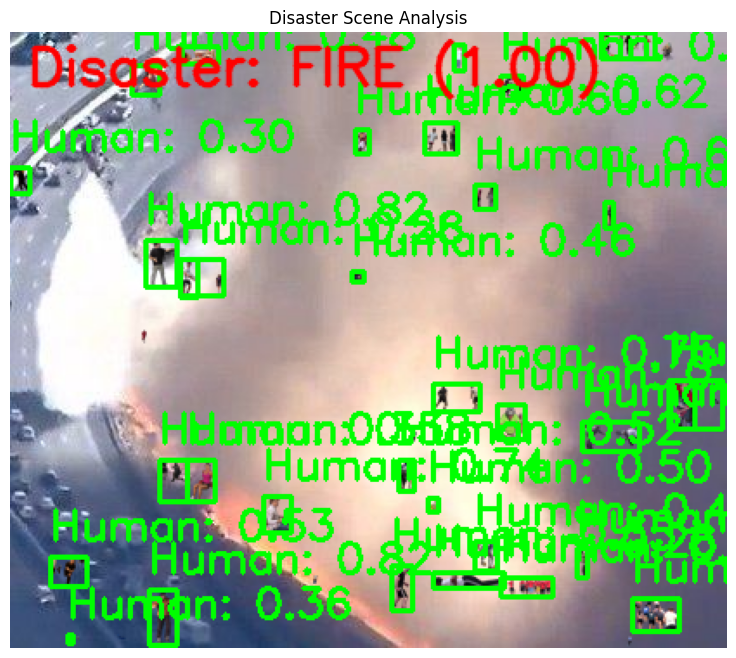

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Assume 'integrated_system' object is initialized from the previous step
# Assume 'disaster_types' list is defined

def visualize_disaster_analysis(image_path, analysis_report, save_path=None):
    """
    Visualizes the disaster analysis results on the image.

    Args:
        image_path (str): Path to the original image.
        analysis_report (dict): The analysis report generated by IntegratedDisasterSystem.analyze_scene.
        save_path (str, optional): Path to save the visualized image. Defaults to None.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f" Error loading image for visualization: {image_path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img_rgb.shape

    # Draw bounding boxes for detected humans
    detections = analysis_report.get('human_detection', {}).get('detections', [])
    for det in detections:
        bbox = det['bbox']
        confidence = det['confidence']
        x1, y1, x2, y2 = bbox
        # Ensure coordinates are within image bounds
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(width, x2), min(height, y2)
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green bounding box
        label = f"Human: {confidence:.2f}"
        cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Add classified disaster type text
    disaster_info = analysis_report.get('disaster_classification', {})
    disaster_type = disaster_info.get('type', 'Unknown')
    disaster_confidence = disaster_info.get('confidence', 0.0)

    disaster_text = f"Disaster: {disaster_type.upper()} ({disaster_confidence:.2f})"
    cv2.putText(img_rgb, disaster_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA) # Red text

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title("Disaster Scene Analysis")
    plt.axis('off')
    plt.show()

    # Save the visualized image
    if save_path:

        cv2.imwrite(save_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
        print(f" Visualized analysis saved to: {save_path}")

visualize_disaster_analysis(f"/content/c2a_dataset/C2A_Dataset/new_dataset3/test/images/fire_image0094_2.png", integrated_system.analyze_scene(f"/content/c2a_dataset/C2A_Dataset/new_dataset3/test/images/fire_image0094_2.png"))



## Batch Processing and Area Summary

### Subtask:
Create a function to process multiple images from a folder and provide a summary analysis for the entire area.

**Reasoning**:
Define a function that takes a folder path, iterates through the image files in the folder, calls the `analyze_scene` method for each image, and then aggregates the results to generate a summary report for the area.

 PROCESSING DISASTER AREA: /content/c2a_dataset/C2A_Dataset/new_dataset3/test/images
Processing 5 randomly selected images as requested.
Found 5 images to process.

--- Processing Image 1/5: collapsed_building_image0150_1.png ---

--- Analyzing Scene: collapsed_building_image0150_1.png ---
 Classified Disaster Type: COLLAPSED_BUILDING (Confidence: 1.00)
Humans Detected: 13
 Human Density Category: High Density
Recommended Resources:
   1. Multiple rescue teams (heavy urban search and rescue)
   2. Medical triage setup
   3. Temporary shelters
   4. Food and water supplies


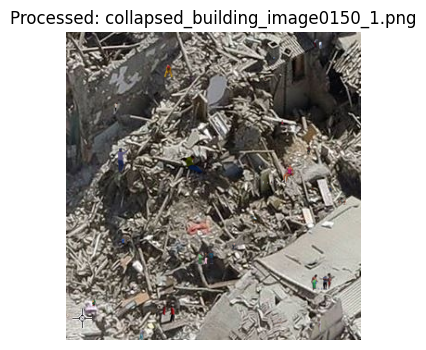


--- Processing Image 2/5: fire_image0294_2.png ---

--- Analyzing Scene: fire_image0294_2.png ---
 Classified Disaster Type: FIRE (Confidence: 1.00)
Humans Detected: 35
 Human Density Category: High Density
Recommended Resources:
   1. Multiple firefighting units (regional support)
   2. Medical triage setup
   3. Temporary shelters
   4. Evacuation plans


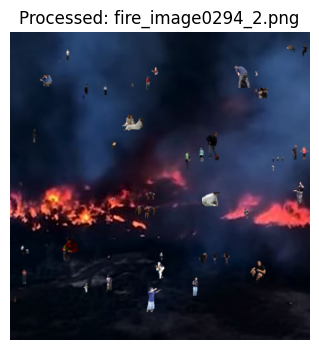


--- Processing Image 3/5: flood_image0031_2.png ---

--- Analyzing Scene: flood_image0031_2.png ---
 Classified Disaster Type: FLOOD (Confidence: 0.77)
Humans Detected: 20
 Human Density Category: High Density
Recommended Resources:
   1. Multiple water rescue teams (boats/helicopters)
   2. Medical triage setup
   3. Temporary shelters
   4. Food and water supplies
   5. Evacuation plans


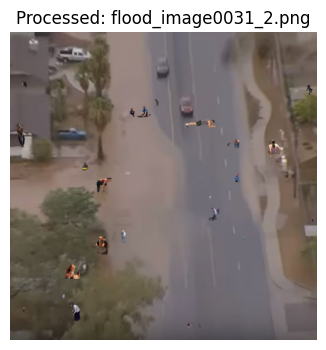


--- Processing Image 4/5: fire_image0106_2.png ---

--- Analyzing Scene: fire_image0106_2.png ---
 Classified Disaster Type: FIRE (Confidence: 1.00)
Humans Detected: 18
 Human Density Category: High Density
Recommended Resources:
   1. Multiple firefighting units (regional support)
   2. Medical triage setup
   3. Temporary shelters
   4. Evacuation plans


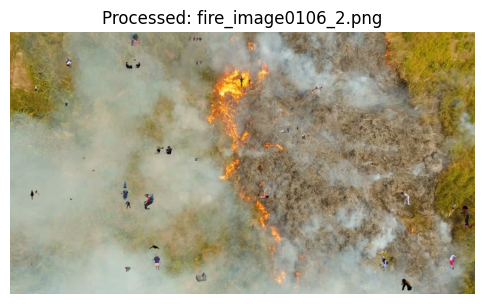


--- Processing Image 5/5: flood_image0525_1.png ---

--- Analyzing Scene: flood_image0525_1.png ---
 Classified Disaster Type: FLOOD (Confidence: 0.99)
Humans Detected: 20
 Human Density Category: High Density
Recommended Resources:
   1. Multiple water rescue teams (boats/helicopters)
   2. Medical triage setup
   3. Temporary shelters
   4. Food and water supplies
   5. Evacuation plans


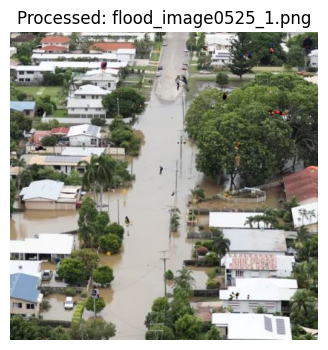

In [76]:
import os
import json
import matplotlib.pyplot as plt # Import matplotlib
import cv2 # Import cv2
import random # Import random

# Assume 'integrated_system' object is initialized from the previous step

def process_disaster_area(folder_path, max_images=None):
    """
    Process multiple images from a disaster area folder and provide a summary.

    Args:
        folder_path (str): Path to the folder containing disaster images.
        max_images (int, optional): Maximum number of images to process. Defaults to None (process all images).

    Returns:
        list: A list of analysis reports for each processed image.
    """
    print(f" PROCESSING DISASTER AREA: {folder_path}")
    print("=" * 60)

    image_files = []
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            # Check for common image file extensions
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                image_files.append(os.path.join(folder_path, file))
        # image_files.sort() # Removed sorting for random selection

    else:
        print(f" Error: Folder not found at {folder_path}")
        return []

    if not image_files:
        print(f"⚠️ No image files found in {folder_path}")
        return []

    # Shuffle the image files for random selection
    random.shuffle(image_files)

    # Limit the number of images if max_images is specified
    if max_images is not None:
        # Ensure max_images does not exceed the total number of images
        max_images = min(max_images, len(image_files))
        image_files = image_files[:max_images]
        print(f"Processing {len(image_files)} randomly selected images as requested.")


    # Process each image
    analysis_reports = []
    print(f"Found {len(image_files)} images to process.")
    for i, img_path in enumerate(image_files):
        print(f"\n--- Processing Image {i+1}/{len(image_files)}: {os.path.basename(img_path)} ---")
        try:
            report = integrated_system.analyze_scene(img_path)
            if report:
                analysis_reports.append(report)
                # Display the image after analysis
                img = cv2.imread(img_path)
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.figure(figsize=(6, 4)) # Smaller figure size for batch display
                    plt.imshow(img_rgb)
                    plt.title(f"Processed: {os.path.basename(img_path)}")
                    plt.axis('off')
                    plt.show()
                else:
                    print(f" Could not load image for display: {os.path.basename(img_path)}")

        except Exception as e:
            print(f" Error processing image {os.path.basename(img_path)}: {e}")





    return analysis_reports

# Example Usage (assuming integrated_system is initialized and you have a folder path):
# sample_folder_path = '/content/c2a_dataset/C2A_Dataset/new_dataset3/val/collapsed_building' # Replace with your folder path
sample_folder_path = '/content/c2a_dataset/C2A_Dataset/new_dataset3/test/images' # Using the test images folder
area_analysis_results = process_disaster_area(sample_folder_path, max_images=5) # Process 5 images # Modified here
# print("\nFinished processing disaster area.")

## System Demo

### Subtask:
Develop a demo to showcase the complete system's capabilities using sample disaster images.

In [79]:

def run_system_demo():
    """Demonstrate the complete rescue system using a sample folder"""
    import json # Import json here
    import pandas as pd # Import pandas here
    import os # Import os here
    from IPython.display import display, Image # Import display and Image here

    print(" AI DISASTER DETECTION & RESCUE SYSTEM DEMO (Folder Processing)")
    print("=" * 50)

    sample_folder_path = '/content/c2a_dataset/C2A_Dataset/new_dataset3/test/images' # Example test images folder

    if os.path.exists(sample_folder_path):
        print(f" Processing sample folder: {sample_folder_path}")

        # Use the process_disaster_area function to analyze the folder
        # You can adjust max_images if you don't want to process all images in the folder
        area_analysis_results = process_disaster_area(sample_folder_path, max_images=5) # Process up to 5 images

        if area_analysis_results:
             print(f"\n SYSTEM STATUS: OPERATIONAL")
             print(f" Demo completed for folder: {sample_folder_path}")

             # Optionally save area analysis results to Google Drive
             summary_save_path = '/content/drive/MyDrive/demo_area_summary_report.json'
             try:
                with open(summary_save_path, 'w') as f:
                    json.dump(area_analysis_results, f, indent=2)
                print(" Area analysis reports saved to Google Drive")
             except Exception as e:
                print(f" Error saving area analysis reports to Google Drive: {e}")

        else:
            print(" No analysis reports generated from the sample folder.")

    else:
        print(f" Sample folder not found at {sample_folder_path}")
        print("Please adjust the 'sample_folder_path' in the demo function.")

run_system_demo()

Integrated Disaster System Initialized

 Integrated Disaster System Initialized Successfully!
 AI DISASTER DETECTION & RESCUE SYSTEM DEMO
 No images available for demo
Please ensure the dataset extraction step was successful and the 'images' list is populated.
